In [1]:
import sys
import os

# Voeg het pad toe aan sys.path
module_path = os.path.abspath(r'H:\My Documents\CapstoneAI-FiberProbe-main')  # of een specifiek pad zoals: '/mnt/data'
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
### Start user input ###
path_to_data = r'U:\Bubble Column\Data\2412_Capstone AI\Capstone data\Data'
path_to_output = r'H:\My Documents\Capstone results'
### End user input ###

# Libary imports
import pandas as pd
import torch
import numpy as np
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Function imports
from advanced_dataloading import process_folder
from advanced_preprocessing import frame_waves, valid_velo_data, save_second_scaler, random_noise, duplicate_and_augment_data, flatten_data_distribution, bin_data, calculate_duplication_factors
from models import load_scalers, load_models, LSTMModel, GRUModel
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [3]:
df = process_folder(path_to_data, path_to_output, plot=False, labels=True)
feature_scaler, target_scaler, X_train, y_train, X_val, y_val, X_test, y_test = save_second_scaler(df)

Binlog data extracted
{'channelCoef1': 0.0, 'channelCoef2': 6.103701895199438e-05, 'acquisitionFrequency': 20833333.333333332, 'flowRate': 60, 'bin_file': '2024-11-12T145426.bin'}
1482760632 datapoints extracted
LABELS: 916 bubble labels with VeloOut != -1 extracted.
Saved bubbles to H:\My Documents\Capstone results\60_2024-11-12T145426_bubbles.csv
No missing labels.
EXTRACTED: 916 bubbles have VeloOut != -1 out of 3437 total bubbles.
            bubble_idx E_idx L_idx   VeloOut  \
0  0_2024-11-12T145426    E0    -1 -1.000000   
1  1_2024-11-12T145426    E1    -1 -1.000000   
2  2_2024-11-12T145426    E2    -1 -1.000000   
3  3_2024-11-12T145426    E3    -1 -1.000000   
4  4_2024-11-12T145426    E4    L0  0.683939   

                                          VoltageOut  FlowRate     Frequency  
0  [0.7072969675064087, 0.6999114751815796, 0.673...        60  2.083333e+07  
1  [0.7262794971466064, 0.7157200574874878, 0.697...        60  2.083333e+07  
2  [0.730491042137146, 0.7262794971

In [4]:
chance = 0.3
bins = 20
X_train, y_train = random_noise(X_train, y_train, chance, random_seed = 0)
hist, bin_indices = bin_data(y_train, bins)
factors = calculate_duplication_factors(hist)
X_train, y_train = duplicate_and_augment_data(X_train, y_train, bin_indices, factors, noise=0.005)
X_train, y_train = flatten_data_distribution(X_train, y_train, bins, scaling_factor=0.5, noise=0.005)

Epoch 1/1500 - Train Loss: 3.9962 - Val Loss: 3.4893
Epoch 100/1500 - Train Loss: 0.1806 - Val Loss: 0.1658
Epoch 200/1500 - Train Loss: 0.0265 - Val Loss: 0.0262
Epoch 300/1500 - Train Loss: 0.0130 - Val Loss: 0.0128
Epoch 400/1500 - Train Loss: 0.0075 - Val Loss: 0.0078
Epoch 500/1500 - Train Loss: 0.0054 - Val Loss: 0.0061
Epoch 600/1500 - Train Loss: 0.0032 - Val Loss: 0.0032
Epoch 700/1500 - Train Loss: 0.0031 - Val Loss: 0.0031
Epoch 800/1500 - Train Loss: 0.0025 - Val Loss: 0.0025
Epoch 900/1500 - Train Loss: 0.0389 - Val Loss: 0.0377
Epoch 1000/1500 - Train Loss: 0.0149 - Val Loss: 0.0148
Epoch 1100/1500 - Train Loss: 0.0086 - Val Loss: 0.0086
Epoch 1200/1500 - Train Loss: 0.0047 - Val Loss: 0.0047
Epoch 1300/1500 - Train Loss: 0.0032 - Val Loss: 0.0032
Epoch 1400/1500 - Train Loss: 0.0561 - Val Loss: 0.0505
Epoch 1500/1500 - Train Loss: 0.0063 - Val Loss: 0.0062


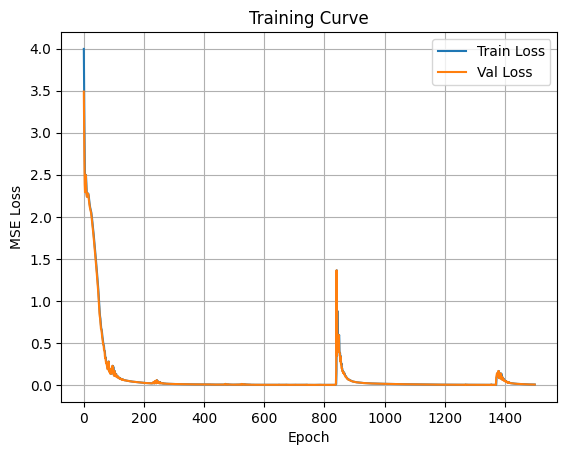

In [5]:
X_train_tensor = torch.tensor(X_train[..., np.newaxis], dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val[..., np.newaxis], dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_val_tensor = X_train_tensor.to(device)
y_val_tensor = y_train_tensor.to(device)

# Model config from your best setup
gru1_model = GRUModel(input_size=1, hidden_size=20, num_layers=2)
gru1_model.to(device)

# Loss and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(gru1_model.parameters(), lr=0.01)

# Training loop
epochs = 1500
train_losses, val_losses = [], []

for epoch in range(epochs):
    gru1_model.train()
    optimizer.zero_grad()
    y_pred_train = gru1_model(X_train_tensor)
    loss = criterion(y_pred_train, y_train_tensor)
    loss.backward()
    optimizer.step()

    gru1_model.eval()
    with torch.no_grad():
        y_pred_val = gru1_model(X_val_tensor)
        val_loss = criterion(y_pred_val, y_val_tensor)

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    if (epoch+1) % 100 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {loss.item():.4f} - Val Loss: {val_loss.item():.4f}")

# Plot loss curve
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Curve")
plt.legend()
plt.grid(True)
plt.show()

In [6]:
# Predict on validation set
gru1_model.eval()
with torch.no_grad():
    y_pred_scaled = gru1_model(X_val_tensor).detach().cpu().numpy().flatten()

# Inverse-transform
y_pred_gru1 = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_true = target_scaler.inverse_transform(y_val_tensor.cpu().numpy().reshape(-1, 1)).flatten()

# Metrics
rmse = mean_squared_error(y_true, y_pred_gru1)
mae = mean_absolute_error(y_true, y_pred_gru1)
r2 = r2_score(y_true, y_pred_gru1)

print(f"RMSE: {rmse:.3f} cm/s")
print(f"MAE: {mae:.3f} cm/s")
print(f"R² Score: {r2:.3f}")

RMSE: 0.001 cm/s
MAE: 0.016 cm/s
R² Score: 0.997


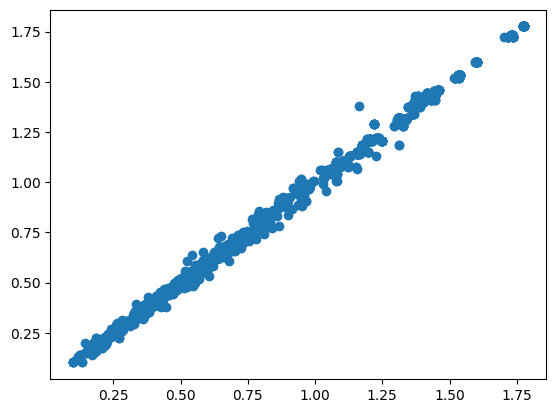

In [7]:
plt.figure()
plt.scatter(y_pred_gru1,y_true)
plt.show()

Epoch 1/700 - Train Loss: 3.2479 - Val Loss: 2.6726
Epoch 50/700 - Train Loss: 0.2869 - Val Loss: 0.3256
Epoch 100/700 - Train Loss: 0.1273 - Val Loss: 0.1058
Epoch 150/700 - Train Loss: 0.0380 - Val Loss: 0.0376
Epoch 200/700 - Train Loss: 0.0214 - Val Loss: 0.0211
Epoch 250/700 - Train Loss: 0.0407 - Val Loss: 0.0303
Epoch 300/700 - Train Loss: 0.0094 - Val Loss: 0.0092
Epoch 350/700 - Train Loss: 0.0059 - Val Loss: 0.0058
Epoch 400/700 - Train Loss: 0.0043 - Val Loss: 0.0047
Epoch 450/700 - Train Loss: 0.0046 - Val Loss: 0.0046
Epoch 500/700 - Train Loss: 0.0025 - Val Loss: 0.0025
Epoch 550/700 - Train Loss: 0.0021 - Val Loss: 0.0021
Epoch 600/700 - Train Loss: 0.0018 - Val Loss: 0.0018
Epoch 650/700 - Train Loss: 0.0016 - Val Loss: 0.0016
Epoch 700/700 - Train Loss: 0.0017 - Val Loss: 0.0014


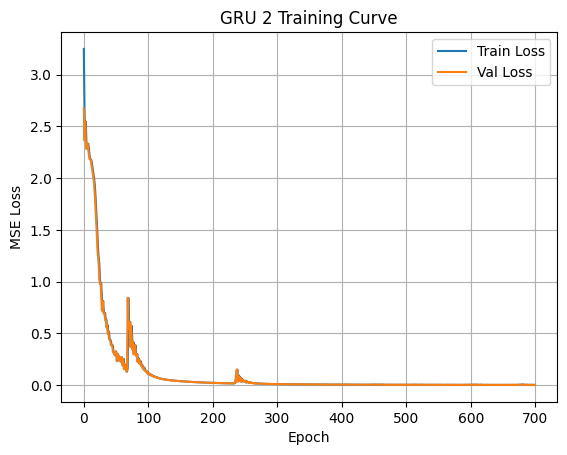

In [8]:
gru2_model = GRUModel(input_size=1, hidden_size=20, num_layers=2)
gru2_model.to(device)

# Optimizer and loss
optimizer = torch.optim.Adam(gru2_model.parameters(), lr=0.02)
criterion = torch.nn.MSELoss()

# Training
epochs = 700
train_losses, val_losses = [], []

for epoch in range(epochs):
    gru2_model.train()
    optimizer.zero_grad()
    pred_train = gru2_model(X_train_tensor)
    loss = criterion(pred_train, y_train_tensor)
    loss.backward()
    optimizer.step()

    gru2_model.eval()
    with torch.no_grad():
        pred_val = gru2_model(X_val_tensor)
        val_loss = criterion(pred_val, y_val_tensor)

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    if (epoch+1) % 50 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {loss.item():.4f} - Val Loss: {val_loss.item():.4f}")

# Plot
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("GRU 2 Training Curve")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.legend()
plt.show()

In [9]:
# Predict on validation set
gru2_model.eval()
with torch.no_grad():
    y_pred_scaled = gru2_model(X_val_tensor).detach().cpu().numpy().flatten()

# Inverse-transform
y_pred_gru2 = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_true = target_scaler.inverse_transform(y_val_tensor.cpu().numpy().reshape(-1, 1)).flatten()

# Metrics
rmse = mean_squared_error(y_true, y_pred_gru2)
mae = mean_absolute_error(y_true, y_pred_gru2)
r2 = r2_score(y_true, y_pred_gru2)

print(f"RMSE: {rmse:.3f} cm/s")
print(f"MAE: {mae:.3f} cm/s")
print(f"R² Score: {r2:.3f}")

RMSE: 0.000 cm/s
MAE: 0.007 cm/s
R² Score: 0.999


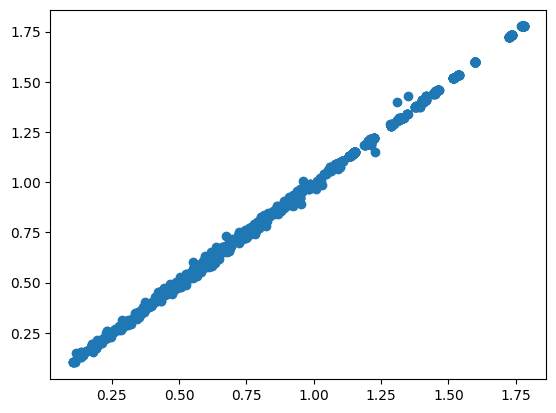

In [10]:
plt.figure()
plt.scatter(y_pred_gru2,y_true)
plt.show()

Epoch 1/3000 - Train Loss: 3.6044 - Val Loss: 3.4490
Epoch 100/3000 - Train Loss: 1.3647 - Val Loss: 1.2835
Epoch 200/3000 - Train Loss: 0.2287 - Val Loss: 0.2255
Epoch 300/3000 - Train Loss: 2.2988 - Val Loss: 2.3043
Epoch 400/3000 - Train Loss: 2.2426 - Val Loss: 2.2386
Epoch 500/3000 - Train Loss: 2.1083 - Val Loss: 2.1060
Epoch 600/3000 - Train Loss: 2.1699 - Val Loss: 2.1686
Epoch 700/3000 - Train Loss: 2.0272 - Val Loss: 2.0262
Epoch 800/3000 - Train Loss: 1.7033 - Val Loss: 1.6963
Epoch 900/3000 - Train Loss: 2.2135 - Val Loss: 2.2128
Epoch 1000/3000 - Train Loss: 2.0796 - Val Loss: 2.0778
Epoch 1100/3000 - Train Loss: 2.0653 - Val Loss: 2.0635
Epoch 1200/3000 - Train Loss: 1.9771 - Val Loss: 1.9764
Epoch 1300/3000 - Train Loss: 1.7472 - Val Loss: 1.7431
Epoch 1400/3000 - Train Loss: 1.5026 - Val Loss: 1.4841
Epoch 1500/3000 - Train Loss: 1.3266 - Val Loss: 1.3280
Epoch 1600/3000 - Train Loss: 1.1212 - Val Loss: 1.1248
Epoch 1700/3000 - Train Loss: 0.9812 - Val Loss: 1.0053
Epoc

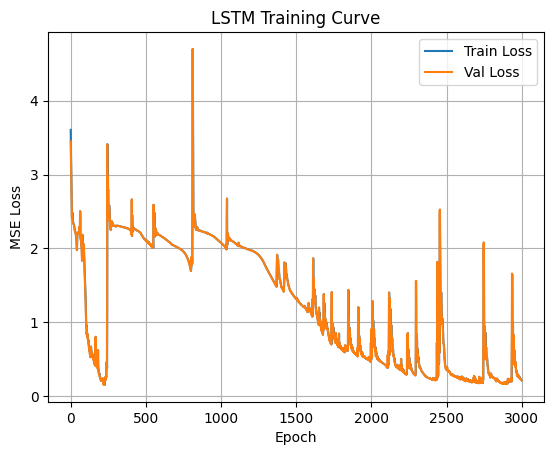

In [11]:
lstm_model = LSTMModel(input_size=1, hidden_size=25, num_layers=2)
lstm_model.to(device)

# Loss and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.006)

# Training loop
epochs = 3000

train_losses, val_losses = [], []

for epoch in range(epochs):
    lstm_model.train()
    optimizer.zero_grad()
    y_pred_train = lstm_model(X_train_tensor)
    loss = criterion(y_pred_train, y_train_tensor)
    loss.backward()
    optimizer.step()

    lstm_model.eval()
    with torch.no_grad():
        y_pred_val = lstm_model(X_val_tensor)
        val_loss = criterion(y_pred_val, y_val_tensor)

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    if (epoch+1) % 100 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {loss.item():.4f} - Val Loss: {val_loss.item():.4f}")

# Plot loss curves
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("LSTM Training Curve")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.legend()
plt.show()

In [12]:
# Predict on validation set
lstm_model.eval()
with torch.no_grad():
    y_pred_scaled = lstm_model(X_val_tensor).detach().cpu().numpy().flatten()

# Inverse-transform
y_pred_lstm = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_true = target_scaler.inverse_transform(y_val_tensor.cpu().numpy().reshape(-1, 1)).flatten()

# Metrics
rmse = mean_squared_error(y_true, y_pred_lstm)
mae = mean_absolute_error(y_true, y_pred_lstm)
r2 = r2_score(y_true, y_pred_lstm)

print(f"RMSE: {rmse:.3f} cm/s")
print(f"MAE: {mae:.3f} cm/s")
print(f"R² Score: {r2:.3f}")

RMSE: 0.020 cm/s
MAE: 0.095 cm/s
R² Score: 0.911


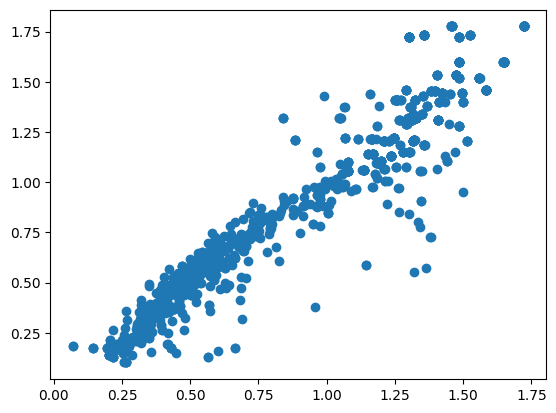

In [13]:
plt.figure()
plt.scatter(y_pred_lstm,y_true)
plt.show()

In [126]:
X_test = feature_scaler.transform(X_test)
y_test = target_scaler.transform(y_test.reshape(-1, 1)).flatten()
X_test_scaled = torch.tensor(X_test[..., np.newaxis], dtype=torch.float32)
y_test_scaled = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)
X_test_scaled = X_test_scaled.to(device)
y_test_scaled = y_test_scaled.to(device)

In [127]:
with torch.no_grad():  
    y_gru1_scaled = gru1_model(X_test_scaled)
    y_gru2_scaled = gru2_model(X_test_scaled)
    y_lstm_scaled = lstm_model(X_test_scaled)
    
y_gru1 = target_scaler.inverse_transform(y_gru1_scaled.detach().cpu().numpy().reshape(-1, 1)).flatten()
y_gru2 = target_scaler.inverse_transform(y_gru2_scaled.detach().cpu().numpy().reshape(-1, 1)).flatten()
y_lstm = target_scaler.inverse_transform(y_lstm_scaled.detach().cpu().numpy().reshape(-1, 1)).flatten()

y_pred = ((y_lstm+y_gru1+y_gru2)/3).flatten()
outcome_df = pd.DataFrame({"predictions model 1": y_gru1, "predictions model 2": y_gru2, "predictions model 3": y_lstm, "final prediction": y_pred})
outcome_df['Standard deviation'] = outcome_df[["predictions model 1", "predictions model 2", "predictions model 3"]].std(axis=1)
outcome_df['Standard deviation %'] = outcome_df['Standard deviation'] / outcome_df['final prediction'] * 100
 
print(outcome_df.head(10))

   predictions model 1  predictions model 2  predictions model 3  \
0             1.303667             2.030286            -0.053530   
1             1.698361             1.000705            -0.139644   
2             1.484423             2.010704            -0.206953   
3             1.304065             2.011540            -0.145784   
4             1.494190             2.010177            -0.206967   
5             1.470381             2.009259            -0.086141   
6             1.565001             2.011185            -0.206864   
7             1.488997             2.010333            -0.145375   
8             1.304087             2.012606             0.141525   
9             1.588423             2.010282            -0.206967   

   final prediction  Standard deviation  Standard deviation %  
0          1.093474            1.057690             96.727448  
1          0.853141            0.927846            108.756485  
2          1.096058            1.158715            105.7165

In [ ]:
# Evaluation metrics (remove '''...''' if interested)
valid_bubbles_ai = len(outcome_df[outcome_df['Standard deviation %'] < 10])/len(outcome_df) * 100
valid_bubbles_boring_software = len(valid_velo_data(df)[0])/len(df) * 100

X_velo, y_velo = valid_velo_data(df)
X_velo_scaled = torch.tensor(feature_scaler.transform(X_velo)[...,np.newaxis], dtype=torch.float32)
X_velo_scaled = X_velo_scaled.to(device)
with torch.no_grad():  
        y_gru1_scaled_velo = gru1_model(X_velo_scaled)
        y_gru2_scaled_velo = gru2_model(X_velo_scaled)
        y_lstm_scaled_velo = lstm_model(X_velo_scaled)
y_gru1_velo = target_scaler.inverse_transform(y_gru1_scaled_velo.detach().cpu().numpy().reshape(-1, 1)).flatten()
y_gru2_velo = target_scaler.inverse_transform(y_gru2_scaled_velo.detach().cpu().numpy().reshape(-1, 1)).flatten()
y_lstm_velo = target_scaler.inverse_transform(y_lstm_scaled_velo.detach().cpu().numpy().reshape(-1, 1)).flatten()
y_pred_velo = ((y_lstm_velo+y_gru1_velo+y_gru2_velo)/3).flatten()
outcome_df_valid = pd.DataFrame({"predictions model 1": y_gru1_velo, "predictions model 2": y_gru2_velo, "predictions model 3": y_lstm_velo, "final prediction": y_pred_velo})
outcome_df_valid['Standard deviation'] = outcome_df_valid[["predictions model 1", "predictions model 2", "predictions model 3"]].std(axis=1)
outcome_df_valid['Standard deviation %'] = outcome_df_valid['Standard deviation'] / outcome_df_valid['final prediction'] * 100
valid_test_results = outcome_df_valid[(outcome_df_valid["Standard deviation"]/outcome_df_valid["final prediction"]) <= 0.1]

filtered_outcome_df = outcome_df[outcome_df['Standard deviation %'] < 10]
average_percentage_std = filtered_outcome_df['Standard deviation %'].mean()

print(f"Percentage found valid bubbles (uncertainty < 10%) with speed difference <10% from truth:  {len(valid_test_results) / (len(outcome_df_valid)) * 100:.4f} %")
print(f'Percentage AI found valid bubbles (uncertainty < 10%): {valid_bubbles_ai:.4f} % vs M2 analyzer: {valid_bubbles_boring_software:.4f} %, improvement: {((valid_bubbles_ai - valid_bubbles_boring_software)/valid_bubbles_boring_software)*100:.4f} %')
print(f'Model uncertainty (average uncertainty of valid bubbles): {average_percentage_std:.4f} % with {len(filtered_outcome_df) / len(outcome_df_valid) * 100} % of the labled samples')
